In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import datetime
import numpy as np
import pandas as pd
import rioxarray as rxr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import polars as pl #libs for faster data processing


from dateutil import tz
import geopandas as gpd

from pyproj import CRS


import sklearn.metrics as metrics
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression


os.chdir('/Users/gaurav/UAH/temperature_modelling/')

#Custom modules
import lib.satellite as sat
import lib.dataprocess as dp 
import lib.crowdqc as cqc
from lib import helper
from lib import modeller as mod
from lib import visualizer



#For the issue with .loc[]
pd.options.mode.chained_assignment = None

### Step 1 : Clean Data 

Run     : python lib/cleaner.py Madison 2021 <br>
Output  : New clean data saved in /Users/gaurav/UAH/temperature_modelling/data/processed_data/Madison_2021/clean_Madison_pws_.csv

In [2]:
#updating necessary columns from satellite
necessary_col_sat = ['station', 'beg_time', 'latitude', 'longitude', 
                # 'humidityAvg',
                  'temperature',
               # 'windspeed', 'dewpt', 'heatindex', 'precipRate',
               'day_of_year',
               'hour', 'adjusted_lst', 'valueImperviousfraction', 'valueTreefraction',
               'valueBuildingheight', 'valueNearestDistWater', 'valueWaterfraction',
              #  'valueLandcover', 
               'valueBuildingfraction']

#updating temporal columns
spatial_columns = [ 'station', 'beg_time', 'latitude','longitude',
                     'temperature', 
                     'closest_station_1_temp','closest_station_2_temp','closest_station_3_temp',
                     'closest_1_distance','closest_2_distance','closest_3_distance',
                     ]

##### Note : 
# 1. valueLandcover is not included as it is categorical
default_location = 'Madison'
default_year = 2021


## Readin PWS Data
### Step 1 : Clean Data 
#Run     : python lib/cleaner.py Madison 2021 <br>
#Output  : New clean data saved in /Users/gaurav/UAH/temperature_modelling/data/processed_data/Madison_2021/clean_Madison_pws_.csv


In [247]:
#Readin PWS Data
### Step 1 : Clean Data 
# Run     : python lib/cleaner.py Madison 2021 <br>
# Output  : New clean data saved in /Users/gaurav/UAH/temperature_modelling/data/processed_data/Madison_2021/clean_Madison_pws_.csv

clean_data = pd.read_csv('data/processed_data/Madison_2021/clean_Madison_pws_.csv')
# clean_data = pd.read_csv('data/processed_data/Madison_2022/clean_Madison_pws_.csv')
clean_data['beg_time'] = pd.to_datetime(clean_data['beg_time'])
clean_data['hour'] = clean_data['beg_time'].dt.hour

clean_data = clean_data.query("day_of_year >= 120 & day_of_year <= 320")
clean_data.station = clean_data.station.str.upper()

# dp.plot_(clean_data,'day_of_year',200)


In [174]:
# visualizer.plot_(grouped_data,'hour',resample=False)

import pandas as pd
wind_data = pd.read_csv('Analytics/wind_data.csv')
wind_data.DATE = pd.to_datetime(wind_data.DATE)
wind_data = wind_data[(wind_data.DATE.dt.year==2021) & (wind_data.DATE.dt.month==7)]

wind_cols = [k for k in  wind_data.columns if 'wind' in k.lower() or "wnd" in k.lower()]
wind_cols = ['STATION', 'DATE', 'SOURCE',]+ wind_cols
wind_data_ = wind_data[wind_cols]
wind_data_.isna().sum()

wind_data_seg = wind_data_[['STATION', 'DATE','HourlyWindDirection','HourlyWindSpeed']]
# wind_data_mean = wind_data_seg.resample('H', on='DATE').mean().reset_index()
wind_data_seg['hour'] = wind_data_seg.DATE.dt.hour
wind_data_seg = wind_data_seg[(~wind_data_seg.HourlyWindDirection.isna()) & (wind_data_seg.HourlyWindDirection != 'VRB')]

import numpy as np

wind_data_seg['HourlyWindDirection']  = wind_data_seg['HourlyWindDirection'].astype(int)
wind_data_mean = wind_data_seg.groupby(['STATION','hour']).mean().reset_index()
wind_data_mean['horizontal_wind'] =wind_data_mean['HourlyWindSpeed'] * np.cos(np.radians(wind_data_mean['HourlyWindDirection']))
wind_data_mean['vertical_wind'] =wind_data_mean['HourlyWindSpeed'] * np.sin(np.radians(wind_data_mean['HourlyWindDirection']))
# wind_data_mean.to_csv('Analytics/temp_data/wind_data_mean.csv',index=False)
# wind_data_mean = wind_data_mean[[ 'hour', 'horizontal_wind', 'vertical_wind']]
wind_data_mean.to_csv('Analytics/temp_data/wind_data_mean.csv',index=False)

/var/folders/qr/fds_zg7j76g51mq0zmqdqfnc0000gn/T/ipykernel_75218/15239590.py:4: DtypeWarning:

Columns (3,21,27,28,29,31,32,33,38,42,43,44,49,50,52,54,56,64,70,72,73,74,76,77,89,90,96,97,98,99,100,101,102,103,104,105,106,107,108) have mixed types. Specify dtype option on import or set low_memory=False.



### Step 2: Generate Ecostress and Urban Satellite Data

In [248]:
sat.create_station_file('Madison',default_year,urban_data=False)
sat.create_station_file('Madison',default_year,urban_data=True)

# sat.create_station_file('Madison',2022,urban_data=True)

/Users/gaurav/UAH/temperature_modelling/lib/satellite.py:111: FutureWarning:

You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.



/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/interpolated_temperature_01.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/temperature_16.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/temperature_02.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/temperature_14.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/temperature_00.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/interpolated_temperature_17.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory

/Users/gaurav/UAH/temperature_modelling/lib/satellite.py:111: FutureWarning:

You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.



/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/urban_surface_data/Imperviousfraction_madison.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/urban_surface_data/Treefraction_madison.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/urban_surface_data/Buildingheight_madison.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/urban_surface_data/NearestDistWater_madison.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/urban_surface_data/Waterfraction_madison.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/urban_surface_data/Landcover_madison.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/urban_surface_data/Buildingfraction_madison.tif
Urban surface properties file saved in /Users/gaurav/UAH/temperature_

/Users/gaurav/UAH/temperature_modelling/lib/satellite.py:239: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'station_x', 'beg_time_x', 'geometry_x', 'longitude_x', 'latitude_x'} in the result is deprecated and will raise a MergeError in a future version.

/Users/gaurav/UAH/temperature_modelling/lib/satellite.py:239: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'station_x', 'beg_time_x', 'geometry_x', 'longitude_x', 'latitude_x'} in the result is deprecated and will raise a MergeError in a future version.



### Step 4 : Calculate Adjsuted LST


#### Note : 
By now I have access to : <br>
- One **clean_data** dataframe that records hourly temperature for each station for 1 year.
-  **result_df** dataframe that has adjusted LST temperature (i.e. LST-mean(LST)).
- **urban_data** dataframe that has urban surface properties.
    - The **valueLandcover** column is categorical

In [249]:
# This data consists of stations, lat, long, time, temp adjusted lst and all surface values
#The process raster data function is used to download the satellite data and process it
# default_year = '2022'
eco_data = mod.process_raster_data(clean_data,create=False,year=default_year,location=default_location)
eco_data = eco_data[necessary_col_sat]

### Step 5 : EDA of urban surface properties 

### Step 6 : Modelling Data

In [250]:
#This data combines stations with closest stations
temperature_data = helper.find_closest_temperatures(eco_data)

#### Step 6.1 : Strategy for Null Values

1. Filling null closest temperature vallues with interpolation
2. In the future, it can be replaced with second closest or average

#### Step 6.2 : Splitting into sequences


**Model 1 : Linear Regression**

In [98]:
from sklearn.preprocessing import StandardScaler

window_size = 5
#Its here because I don't want to pass final_df everytime
def get_partitions(final_df,col_list,selection_hour,scaler=False):
    ''' Get final split of data based on hour selected
        selection_hour = [1] or None
    '''
    final_df_x = final_df.query(f'hour == {list([selection_hour or list(np.arange(0,24,1))][0])}')
    X_train, X_test, y_train, y_test = mod.get_train_test_data(final_df_x,window_size)
    hour_status = final_df_x.hour.unique()

    d_train, d_test = X_train[col_list], X_test[col_list]

    #if there is no hour column, then its set to none, such that the plotter function behaves accordingly
    # hour_status = True if 'hour' in d_train.columns else False

    if scaler:
        scaler = StandardScaler()

        d_train =  scaler.fit_transform(d_train)
        d_train = pd.DataFrame(d_train,columns=col_list)
        d_test = scaler.transform(d_test)
        d_test = pd.DataFrame(d_test,columns=col_list)

    return [d_train, d_test, y_train, y_test], hour_status


def bulk_model_runner(model,grouped_data,col_list,delete=True,bulk_mode=True,fit = True,residuals=False):
    ''' This function runs the model for all hours and saves the predictions and error
        grouped_data = data grouped by station
        col_list = columns to be used for modelling
        delete = True if you want to delete the contents of directory
        bulk_mode = True if you want to train one model for each hour
        fit = True if you want to fit the model, False if you want to load the model
            will be used for transfer learning
    '''

    #cleaning the directory first
    model_name = model.__class__.__name__
    model_path = os.path.join(mod.MODEL_PATH,model_name)
    if delete:
        helper.clean_directory(model_path)

    new_grouped_data = grouped_data.copy()

    if residuals:
        #group the grouped data by hour to find hourly mean and subtract it from the temperature
        print('Residuals are being subtracted from data')
        new_grouped_data['delta_temp'] = new_grouped_data['temperature']-new_grouped_data.groupby('hour')['temperature'].transform('mean')
        new_grouped_data['old_temperature'] = new_grouped_data['temperature']
        new_grouped_data['temperature'] = new_grouped_data['delta_temp']
        hour_lookup = new_grouped_data.groupby('hour')['old_temperature'].mean().reset_index()

        hour_lookup.to_csv('Analytics/temp_data/hour_lookup.csv',index=False)
        print('Hour lookup saved in Analytics/temp_data/hour_lookup.csv')

    model_dict = {}
    model_output_dict = {}
    if bulk_mode:
        feature_importances_dict = dict()
        for hour_ in range(24):
            data,hour_status = get_partitions(new_grouped_data,col_list,[hour_])  #or None
            predictions,error = mod.train_save(model, data, hour_status)
            try:
                feature_importances = model.feature_importances_
            except:
                feature_importances = None
            model_dict[hour_] = [predictions,error,feature_importances]

        for hour in model_dict.keys():
            feature_importances_dict[hour] = model_dict[hour][2]
            model_dict[hour][0]['hourly_rms'] = model_dict[hour][1]

        hour0 = model_dict[0][0]

        for hour in model_dict.keys():
            if hour != 0:
                hour0 = pd.concat([hour0,model_dict[hour][0]],axis=0)

        model_output_dict['hourly_values'] = hour0
        model_output_dict['feature_importances'] = pd.DataFrame(feature_importances_dict).mean(axis=1).values

        
        
    
    if not bulk_mode:
        data,hour_status = get_partitions(new_grouped_data,col_list,None)
        predictions,error = mod.train_save(model, data, hour_status)
        try:
            feature_importances = model.feature_importances_
        except:
            feature_importances = None
        model_dict['hourly_values'] = [predictions,error,feature_importances]

        #new module to uniformly output data
        combined_df = model_dict['hourly_values'][0]
        hourly_rmse = combined_df.groupby('hour').apply(lambda x : metrics.mean_squared_error(x.predicted_temperature,x.true_temperature,squared=False)).reset_index(name='hourly_rms')
        combined_df = pd.merge(combined_df, hourly_rmse, on='hour')

        model_output_dict['hourly_values'] = combined_df
        model_output_dict['feature_importances'] = model_dict['hourly_values'][2]

    if residuals:
        print('Residuals are being added back to the predictions')
        predictions = model_output_dict['hourly_values']

        model_dict_updated = predictions.merge(hour_lookup,on='hour')
        model_dict_updated['predicted_temperature'] = model_dict_updated['predicted_temperature']+model_dict_updated['old_temperature']
        model_dict_updated['true_temperature'] = model_dict_updated['true_temperature']+model_dict_updated['old_temperature']

        model_output_dict['hourly_values'] = model_dict_updated
    
        
    return model_output_dict

def find_frequent(outliers_dict,number=6):
    hash_map = dict()
    hash_map_tree = dict()

    for hrs in outliers_dict.keys():
        val = outliers_dict[hrs]
        for v in val:
            hash_map[v] = 1 + hash_map.get(v,0)
            hash_map_tree[v] = 1 + hash_map_tree.get(v,0)

    hash_map_tree = {k: v for k, v in sorted(hash_map_tree.items(), key=lambda item: item[1],reverse=True)}
    top_n = {k:v for k,v in sorted(hash_map_tree.items(),key=lambda x: x[1],reverse=True)[:number]}
    return top_n

def combine_hashes(hash1,hash2):
    for k,v in hash2.items():
        hash1[k] = 1 + hash1.get(k,0)
    return hash1

In [172]:
year = 2021
month = 6

beg_time = str(year) + '-' + str(month) + '-01'
end_time = str(year) + '-' + str(month + 1) +'-01'

# temperature_data_segment = temperature_data.query("beg_time >= '2021-05-01' & beg_time < '2021-06-01'")
temperature_data_segment = temperature_data.query(f"beg_time >= '{beg_time}' & beg_time < '{end_time}'")
final_df = mod.get_final_df(temperature_data_segment,eco_data,spatial_columns)
grouped_data = final_df.groupby(['station','hour']).mean().reset_index()

# Data cleaning pipeline 
# cqc.level_1_plot(grouped_data)
print(f'Original station count : {len(grouped_data.station.unique())}')
flag_stations = cqc.cleaning_outliers(grouped_data)
missing_stations = cqc.clean_missing_data(final_df,print_missing=False,missing_count=18)

grouped_data = grouped_data.query("station not in @flag_stations")
grouped_data = grouped_data.query("station not in @missing_stations")
# cqc.level_1_plot(grouped_data)

print(f'Flag station count : {len(flag_stations)}')
print(f'Missing station count : {len(missing_stations)}')
print(f'Final station count : {len(grouped_data.station.unique())}')



Original station count : 118
Flag station count : 7
Missing station count : 4
Final station count : 108


In [173]:
import plotly.express as pe

grouped_data = grouped_data.query("station not in @flag_stations")
grouped_data = grouped_data.query("station not in @missing_stations")
grouped_data['beg_time'] = final_df['beg_time'][0]

#calculating outliers based on quartiles for valueTreefraction and valueImperviousfraction
predictions1,outliers_tree = cqc.filter_quartiles(grouped_data,quantiles=[0.025, 0.97])
predictions2,outliers_impe = cqc.filter_quartiles(grouped_data,feature_column='valueImperviousfraction')

outliers_tree = find_frequent(outliers_tree)
outliers_impe = find_frequent(outliers_impe)


outliers = combine_hashes(outliers_tree,outliers_impe)
outliers_3 = ({k:v for k,v in sorted(outliers.items(),key=lambda x: x[1],reverse=True)[:3]}).keys()

grouped_data.to_csv('Analytics/temp_data/grouped_data_untouched.csv',index=False)

grouped_data = grouped_data.query("station not in @outliers_3")

grouped_data.to_csv('Analytics/temp_data/grouped_data_filtered.csv',index=False)

##the grouped data is saved in the temp_data folder and used for final scatter plots
helper.convert_to_gpd(grouped_data,'epsg:4326',convert_to='epsg:6879')[['hour','latitude','longitude','temperature']].to_csv('Analytics/temp_data/grouped_data.csv',index=False)

print(f'Final station count : {len(grouped_data.station.unique())}')

# pe.scatter(grouped_data, x="hour", y="temperature", color='station', title='Temperature Pattern for Normal Stations',)


Final station count : 105


In [131]:
# pe.scatter(grouped_data, x="hour", y="temperature", color='station', title='Temperature Pattern for Normal Stations')

print(outliers_tree)
print(outliers_impe)
print(outliers)

{'KWIMADIS138': 19, 'KWIMADIS352': 12, 'KWIMADIS334': 11, 'KWIMADIS118': 9, 'KWIMADIS104': 7, 'KWIMADIS35': 5, 'KWIMIDDL25': 1}
{'KWIMADIS138': 17, 'KWIMADIS352': 11, 'KWIMADIS334': 10, 'KWIMADIS104': 6, 'KWIMIDDL25': 5, 'KWIMADIS118': 5}
{'KWIMADIS138': 19, 'KWIMADIS352': 12, 'KWIMADIS334': 11, 'KWIMADIS118': 9, 'KWIMADIS104': 7, 'KWIMADIS35': 5, 'KWIMIDDL25': 1}


In [108]:
if not 'horizontal_wind' in grouped_data.columns:
    grouped_data = grouped_data.merge(wind_data_mean,on='hour')


# grouped_data[grouped_data.hour ==0]

# Model 1 : Random Forest 

Residuals are being subtracted from data
Hour lookup saved in Analytics/temp_data/hour_lookup.csv
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/RandomForestRegressor/RandomForestRegressor_0.sav
Residuals are being added back to the predictions
Time at which model ran : 01/16/24 16:29:07


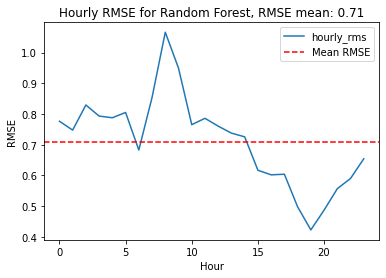

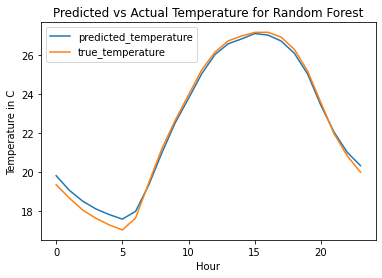

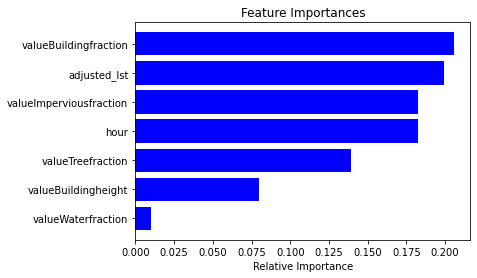

In [109]:
from sklearn.ensemble import RandomForestRegressor

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            # 'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
      #  'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
        #  'horizontal_wind','vertical_wind'
         ]

rrf = RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=8,
                            n_estimators=300)




# model_dict = bulk_model_runner(rrf,grouped_data,col_list,bulk_mode=False,delete=True)
# visualizer.plot_mean(model_dict,'Random Forest',col_list)

model_dict = bulk_model_runner(rrf,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'Random Forest',col_list)




Text(0.5, 1.0, 'Mean and Standard Deviation of Predicted and Actual Temperature :Random Forest')

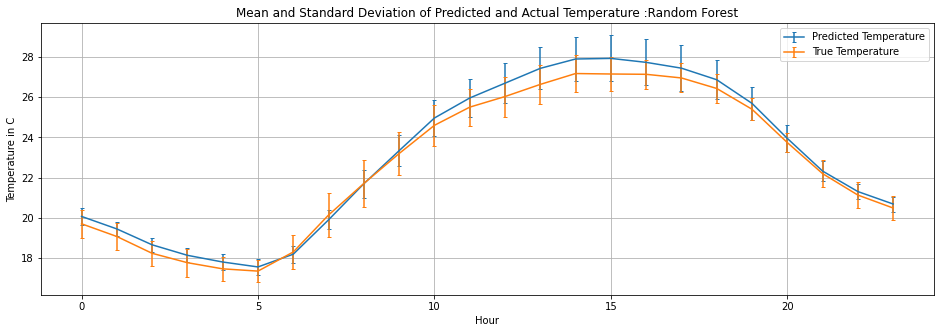

In [152]:
mean_std_matrix = model_dict['hourly_values'].groupby('hour')[['predicted_temperature','true_temperature']].agg(['std','mean']).reset_index()
plt.figure(figsize=(16,5))
plt.errorbar(mean_std_matrix['hour'],mean_std_matrix['predicted_temperature']['mean'],mean_std_matrix['predicted_temperature']['std'],label = 'Predicted Temperature', capsize=2, capthick=1)
plt.errorbar(mean_std_matrix['hour'],mean_std_matrix['true_temperature']['mean'],mean_std_matrix['true_temperature']['std'],label = 'True Temperature', capsize=2, capthick=1)

plt.xlabel('Hour')
plt.ylabel('Temperature in C')
plt.legend()
plt.grid()
plt.title('Mean and Standard Deviation of Predicted and Actual Temperature :Random Forest')



**Model 2 : GBR**

In [118]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

col_list = [
    # 'latitude', 'longitude', 
            'hour',  
            'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
    #    'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
                #   'horizontal_wind','vertical_wind'
        ]
params = {
    'learning_rate': 0.1,  # Learning rate (shrinkage)
    'n_estimators': 300,  # Number of boosting stages
    'max_depth': 5,  # Maximum depth of the individual trees
    'subsample': 0.8,  # Fraction of samples used for fitting the trees (controls overfitting)
    'loss': 'squared_error',  # Least Squares regression
    'alpha': 0.5,  # L1 regularization term (only available in scikit-learn 0.24.0 and later)
}



gbr = GBR(**params)
gbr = GBR(alpha=1.0)


model_dict = bulk_model_runner(gbr,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


Residuals are being subtracted from data
Hour lookup saved in Analytics/temp_data/hour_lookup.csv


ValueError: alpha must be in (0.0, 1.0) but was 1.0

# Model 3 : XGB

Residuals are being subtracted from data
Hour lookup saved in Analytics/temp_data/hour_lookup.csv
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_0.sav
Residuals are being added back to the predictions
Time at which model ran : 01/16/24 16:29:18


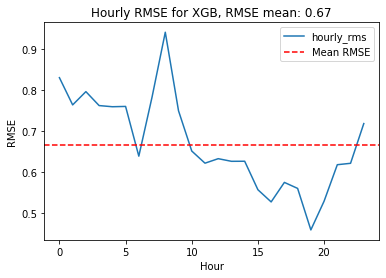

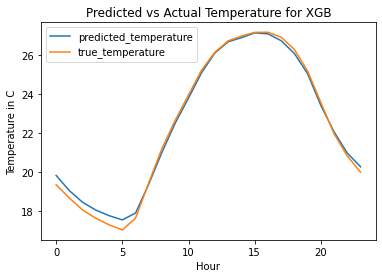

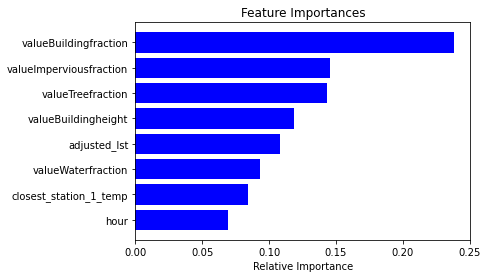

In [111]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.15,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 1,  # L2 regularization term
#     'alpha': 0.5,  # L1 regularization term
# }


params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.035,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.25,  # L2 regularization term
    'alpha': 0.20,  # L1 regularization term
}

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            'closest_station_1_temp',
          # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
      #  'valueNearestDistWater',
         'valueWaterfraction', 
         'valueBuildingfraction',
        #   'horizontal_wind','vertical_wind'
          ]


xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


### Neural Networks

Residuals are being subtracted from data
Hour lookup saved in Analytics/temp_data/hour_lookup.csv
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/MLPRegressor/MLPRegressor_0.sav
Residuals are being added back to the predictions
Time at which model ran : 01/15/24 09:53:54
Feature importances not available


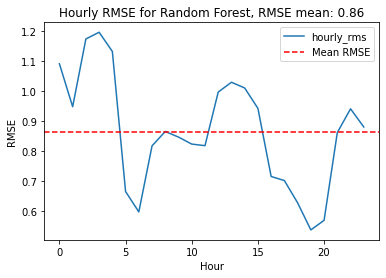

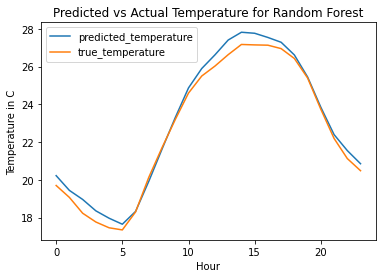

In [193]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

col_list = [
    # 'latitude', 'longitude', 
            'hour',  
        #     'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
    #    'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
                  'horizontal_wind','vertical_wind'
        ]



nn = MLPRegressor(hidden_layer_sizes=(12,10,8,8,4,2),activation='relu', solver='adam', max_iter=500)


model_dict = bulk_model_runner(nn,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'Random Forest',col_list)



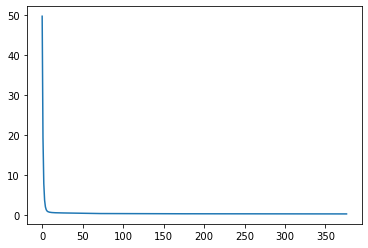

In [194]:
plt.plot(nn.loss_curve_)

In [180]:
# def get_delta_plots(final_dict):
#     ''' Final dict is of format : 
#         { {hour : [predictions,error,feature_importances]}}
#         access : final_dict[0][0],final_dict[5][0]
#     '''
#     df_ = final_dict['hourly_values']
#     df_ = df_[['predicted_temperature','true_temperature','hour','hourly_rms']]
#     # df_['hour']  = 0

#     # for hrs in final_dict.keys():
#     #     if hrs ==0:
#     #         continue
#     #     datax = final_dict[hrs][0]
#     #     datax = datax[['predicted_temperature','true_temperature','hour']]
#     #     datax['hour']  = hrs

#     #     df_ = pd.concat([df_,datax])

#     df_agg = df_.groupby('hour').mean().reset_index()
#     df_agg['delta_temp'] = df_agg.predicted_temperature - df_agg.true_temperature


#     avg_rmse = df_.hourly_rms.mean()

#     df_['station'] = df_.index
#     df_['delta'] = df_.predicted_temperature - df_.true_temperature
#     df_ = df_.reset_index().drop('index',axis=1)


#     import seaborn as sns
#     # sns.set_theme(style="whitegrid")
#     sns.set_style("white")
#     plt.figure(figsize=(15,15))

#     plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
#     sns.lineplot(x=df_agg.hour,y=df_agg.delta_temp)
#     plt.title('Average of Delta Temperature for all stations')
#     plt.xlabel('Hour')
#     plt.grid()

#     plt.ylabel('Delta Temperature')


#     plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
#     sns.lineplot(x = df_agg.hour,y = df_agg.true_temperature,label='True Temperature')
#     sns.lineplot(x = df_agg.hour,y = df_agg.predicted_temperature,label='Predicted Temperature')
#     plt.title(f'True Temperature VS Predicted for test data : Avg RMSE = {round(avg_rmse,3)}')
#     plt.xlabel('Hour')
#     plt.ylabel('Temperature')

#     # Create a subplot that spans the entire second row
#     plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=2)
#     df_['station'] = df_['station'].astype(str)
#     sns.lineplot(x='hour', y='delta', hue='station', data=df_, marker='o')
#     plt.title('Delta Temperature for all stations')
#     # Show the plot)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')



#     # plt.tight_layout()
#     plt.show()

# get_delta_plots(model_dict)

In [220]:
st_list = grouped_data.station.unique()
clean_data = clean_data.query("station in @st_list")
clean_data.loc[clean_data.precipRate >350,'precipRate'] = np.nan

In [221]:
clean_data['month'] = clean_data.beg_time.dt.month


In [222]:
clean_data_grp = clean_data.groupby(['station','month','hour']).mean().reset_index()
clean_data_may = clean_data_grp.query("month == 5")
clean_data_june = clean_data_grp.query("month == 6")
clean_data_july = clean_data_grp.query("month == 7")
clean_data_aug = clean_data_grp.query("month == 8")


In [224]:
clean_data

,station,beg_time,latitude,longitude,humidityAvg,temperature,windspeed,dewpt,heatindex,precipRate,day_of_year,hour,month
6801,KWIFITCH21,2021-05-01 00:00:00,42.997337,-89.439064,48.0,9.0,3.0,-1.0,9.0,0.0,121,0,5
6802,KWIFITCH21,2021-05-01 01:00:00,42.997337,-89.439064,59.0,8.0,5.0,1.0,9.0,0.0,121,1,5
6803,KWIFITCH21,2021-05-01 02:00:00,42.997337,-89.439064,74.0,7.0,4.0,3.0,8.0,0.0,121,2,5
6804,KWIFITCH21,2021-05-01 03:00:00,42.997337,-89.439064,81.0,7.0,5.0,4.0,7.0,0.0,121,3,5
6805,KWIFITCH21,2021-05-01 04:00:00,42.997337,-89.439064,81.0,7.0,7.0,4.0,7.0,0.0,121,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
854435,KWIWINDS10,2021-08-31 19:00:00,43.206000,-89.348000,74.0,20.0,1.0,15.0,20.0,0.0,243,19,8
854436,KWIWINDS10,2021-08-31 20:00:00,43.206000,-89.348000,76.0,18.0,2.0,14.0,19.0,0.0,243,20,8
854437,KWIWINDS10,2021-08-31 21:00:00,43.206000,-89.348000,85.0,16.0,1.0,14.0,17.0,0.0,243,21,8
854438,KWIWINDS10,2021-08-31 22:00:00,43.206000,-89.348000,92.0,15.0,1.0,13.0,15.0,0.0,243,22,8


<AxesSubplot:>

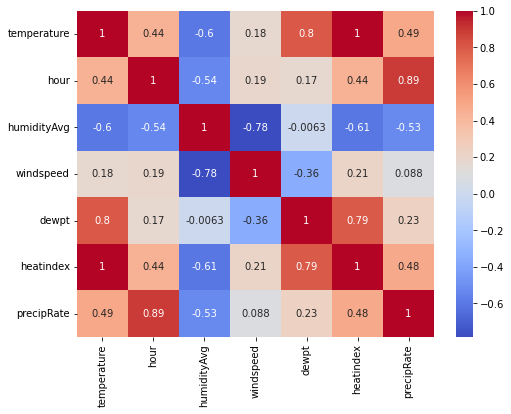

In [243]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(clean_data_grp2[['temperature','hour',  'humidityAvg',
       'windspeed', 'dewpt', 'heatindex', 'precipRate']].corr(),annot=True,cmap='coolwarm')


In [245]:
clean_data_grp2 = clean_data.groupby(['month','hour']).mean().reset_index()

cols = ['dewpt','heatindex','precipRate','humidityAvg']
for col in cols:
    fig = pe.line(clean_data_grp2,x='hour',y=col,color='month',title=f'{col} Pattern for Normal Stations')
    fig.show()